# Projeto de Mineração de Dados (P2 e P3)

- Aluno: Luiz Fernando Costa dos Santos
- Matrícula: 20200025446


O dataset utilizado foi o Adult, que foi retirado do [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/2/adult). Mais informações no arquivo `./data/adult.names` ou no próprio site mencionado acima.

## Importações

In [39]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from typing import *
import hashlib
from sklearn.cluster import KMeans
from typedframe import TypedDataFrame

## Pré-processamentos e carregamento dos dados

In [2]:
normalizacao = lambda x: x - x.min() / x.max() - x.min()

In [3]:
np.random.seed(40)

features_names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income"
]

# ETL

In [116]:
class AdultETL:
    def __init__(self):
        self.initial_data_schema = data_types = {
            'age': 'int8',
            'workclass': 'object',
            'fnlwgt': 'int64',
            'education': 'object',
            'education-num': 'int8',
            'marital-status': 'category',
            'occupation': 'object',
            'relationship': 'category',
            'race': 'category',
            'sex': 'category',
            'capital-gain': 'int64',
            'capital-loss': 'int64',
            'hours-per-week': 'int8',
            'native-country': 'object'
        }
        self.cols_to_create_hash = [
            'age', 
            'workclass', 
            'fnlwgt', 
            'education', 
            'education-num', 
            'marital-status', 
            'occupation', 
            'relationship', 
            'sex', 
            'native-country'
        ]
        self.cols_to_cluster = [
            "age", 
            "fnlwgt", 
            "education-num", 
            "capital-gain", 
            "capital-loss", 
            "hours-per-week"
        ]
        self.save_data_type = "parquet"
        
      
    def __call__(self) -> pd.DataFrame:
        return self.data
    
    def correct_data_types(self):
        for col, dtype in self.initial_data_schema.items():
            if col in self.data.columns:
                self.data[col] = self.data[col].astype(dtype)

    def create_hashed_id(self):
        concatenated_values = self.data[self.cols_to_create_hash].apply(lambda row: ''.join(map(str, row)), axis=1)
        hashed_values = concatenated_values.apply(lambda x: hashlib.sha256(x.encode()).hexdigest())
        self.data['hashed_id'] = hashed_values        
    
    def with_profit(self):
        self.data["capital-profit"] = self.data["capital-gain"] - self.data["capital-loss"]
    
    def with_categorized_data(self):
        string_cols = self.data.select_dtypes(include=["category"]).columns
        self.data[string_cols] = self.data[string_cols].apply(lambda x: x.str.strip()).astype("category")
        self.data["income"] = self.data["income"].apply(lambda x: 1 if x == " >50K" else 0).astype("category")    
        self.data["capital-profit-gt-0"] = self.data["capital-profit"].apply(lambda x: 1 if x > 0 else 0).astype("category")
    
    def with_kmeans(self, k: int, random_state: int = 42):
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        
        input_data_norm = self.data[
            self.cols_to_cluster].apply(normalizacao)
        
        kmeans.fit(input_data_norm)
        self.data["cluster"] = kmeans.labels_
        self.data["cluster"] = self.data["cluster"].astype("category")
        
        
    def extract(self, data_name: str, features_names: List[str]):
        self.data: pd.DataFrame = pd.read_csv(data_name, header=None)
        self.data.columns = features_names
        self.schema = self.data.dtypes
    
    def transform(self, k: int):
        self.correct_data_types()
        self.create_hashed_id()
        self.with_profit()
        self.with_categorized_data()
        self.with_kmeans(k)
        self.schema = self.data.dtypes
    
    def load(self, new_data_name: str):
        if self.save_data_type == "parquet":
            self.data.to_parquet(new_data_name, index=False)
        elif self.save_data_type == "csv":
            self.data.to_csv(new_data_name, index=False)
        else:
            raise ValueError("Invalid save_data_type")
    

In [117]:
etl = AdultETL()

In [118]:
etl.extract("data/adult.data.csv", features_names)

In [119]:
etl.data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [120]:
etl.schema

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

In [122]:
etl.transform(k=5)

In [123]:
etl.data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,hashed_id,capital-profit,capital-profit-gt-0,cluster
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,75429eb96e57d8aaa309fa099562db5761ca0c7bcc28c9...,2174,1,4
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,ac8849cd18724a2b1c9824a13399b022b9c7aeb414d23e...,0,0,4
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,e63a50cf2961ec987b435e549ad9795963dfb9d96ed3cb...,0,0,3
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,3fd2052cb4391f0a4c00c326864a5f2fd53e9eb032d9d2...,0,0,3
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,e5fb50b02464e84ca7b3a8e34ed2ed51c6898af5ec43f0...,0,0,1


In [124]:
etl.load("data/adult.data.processed.parquet")

In [125]:
etl.schema

age                        int8
workclass                object
fnlwgt                    int64
education                object
education-num              int8
marital-status         category
occupation               object
relationship           category
race                   category
sex                    category
capital-gain              int64
capital-loss              int64
hours-per-week             int8
native-country           object
income                 category
hashed_id                object
capital-profit            int64
capital-profit-gt-0    category
cluster                category
dtype: object

## Extract

In [65]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [66]:


def correct_data_types(df):
    data_types = {
        'age': 'int8',
        'workclass': 'object',
        'fnlwgt': 'int64',
        'education': 'object',
        'education-num': 'int8',
        'marital-status': 'category',
        'occupation': 'object',
        'relationship': 'category',
        'race': 'category',
        'sex': 'category',
        'capital-gain': 'int64',
        'capital-loss': 'int64',
        'hours-per-week': 'int8',
        'native-country': 'object'
    }

    for col, dtype in data_types.items():
        if col in df.columns:
            df[col] = df[col].astype(dtype)
    
    return df


def create_hashed_id(df, rows: List[str]):
    concatenated_values = df[rows].apply(lambda row: ''.join(map(str, row)), axis=1)
    
    hashed_values = concatenated_values.apply(lambda x: hashlib.sha256(x.encode()).hexdigest())
    
    df['hashed_id'] = hashed_values
    
    return df

df = correct_data_types(df)
df = create_hashed_id(
    df, 
    ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
)

In [67]:
df.dtypes

age                   int8
workclass           object
fnlwgt               int64
education           object
education-num         int8
marital-status    category
occupation          object
relationship      category
race              category
sex               category
capital-gain         int64
capital-loss         int64
hours-per-week        int8
native-country      object
income              object
hashed_id           object
dtype: object

In [68]:
string_cols = df.select_dtypes(include=["category"]).columns

df[string_cols] = df[string_cols].apply(lambda x: x.str.strip()).astype("category")

In [69]:
string_cols = df.select_dtypes(include=["category"]).columns
df[string_cols] = df[string_cols].apply(lambda x: x.str.strip()).astype("category")
df["income"] = df["income"].apply(lambda x: 1 if x == " >50K" else 0).astype("category")
df["capital-profit"] = df["capital-gain"] - df["capital-loss"]
df["capital-profit-gt-0"] = df["capital-profit"].apply(lambda x: 1 if x > 0 else 0).astype("category")

In [73]:
k_means = KMeans(n_clusters=5, random_state=42)
k_means.fit(df[["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]].apply(normalizacao))
df["cluster"] = k_means.labels_
df["cluster"] = df["cluster"].astype("category")

KMeans(n_clusters=5, random_state=42)

In [81]:
k_means.predict(df[["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]].apply(normalizacao))

array([4, 4, 3, ..., 0, 3, 1], dtype=int32)

In [75]:
df.dtypes.sort_index()

age                        int8
capital-gain              int64
capital-loss              int64
capital-profit            int64
capital-profit-gt-0    category
cluster                category
education                object
education-num              int8
fnlwgt                    int64
hashed_id                object
hours-per-week             int8
income                 category
marital-status         category
native-country           object
occupation               object
race                   category
relationship           category
sex                    category
workclass                object
dtype: object

In [79]:
df.to_parquet("data/adult_data_transformed.parquet", index=False)

## PCA

In [12]:
fac1, fac2, fac3 = PCA(df.select_dtypes(include=["int64", "float64"]))

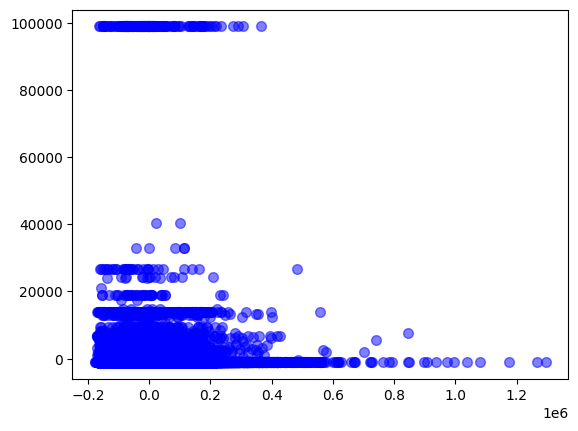

In [16]:
plt.plot(fac1, fac2, 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.show()

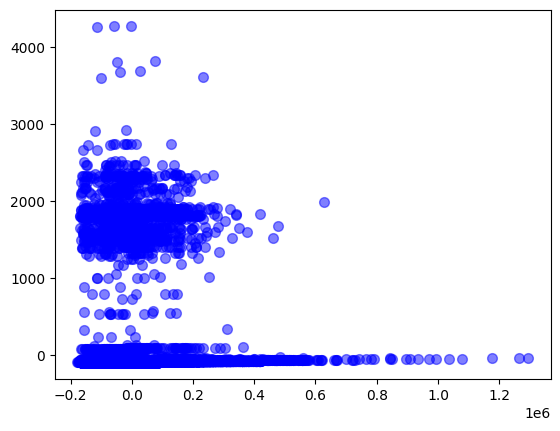

In [17]:
plt.plot(fac1, fac3, 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.show()

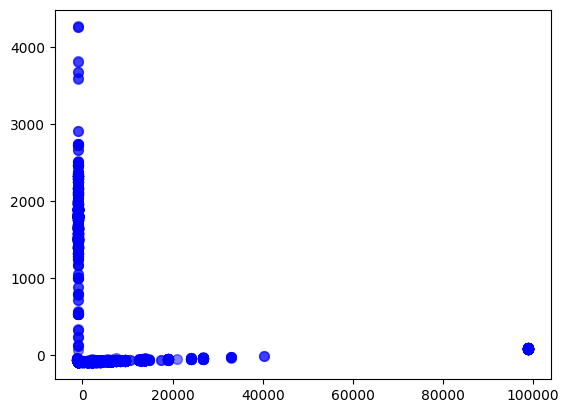

In [18]:
plt.plot(fac2, fac3, 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.show()

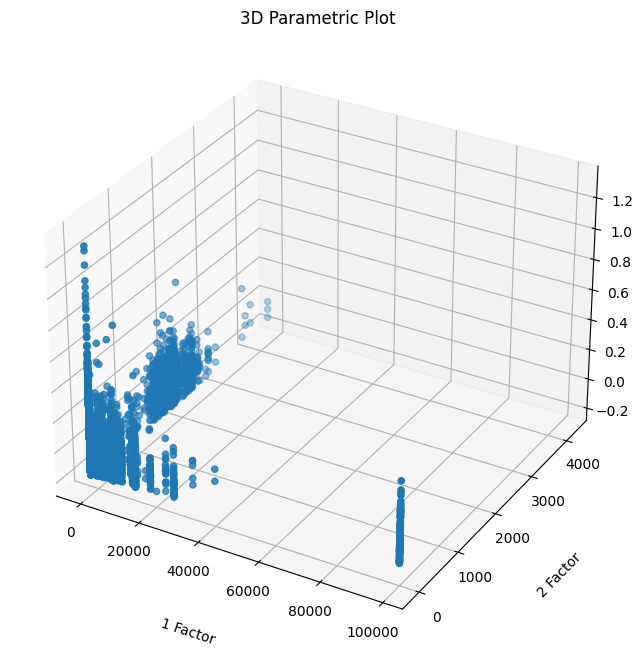

In [22]:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.grid()
t = fac1
x = fac2
y = fac3

ax.scatter3D(x, y, t)
ax.set_title('3D Parametric Plot')

# Set axes label
ax.set_xlabel('1 Factor', labelpad=20)
ax.set_ylabel('2 Factor', labelpad=20)
ax.set_zlabel('3 Factor', labelpad=20)

plt.show()

## Normalização

In [25]:
normalizacao(df.select_dtypes(include=["int64", "float64"]))

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,21.811111,65230.991726,11.9375,2174.0,0.0,38.989899
1,32.811111,71025.991726,11.9375,0.0,0.0,11.989899
2,20.811111,203360.991726,7.9375,0.0,0.0,38.989899
3,35.811111,222435.991726,5.9375,0.0,0.0,38.989899
4,10.811111,326123.991726,11.9375,0.0,0.0,38.989899
...,...,...,...,...,...,...
32556,9.811111,245016.991726,10.9375,0.0,0.0,36.989899
32557,22.811111,142088.991726,7.9375,0.0,0.0,38.989899
32558,40.811111,139624.991726,7.9375,0.0,0.0,38.989899
32559,4.811111,189204.991726,7.9375,0.0,0.0,18.989899


In [26]:
padronizacao(df.select_dtypes(include=["int64", "float64"]))

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,36.171523,77514.202005,9.081704,2173.854082,-0.216656,36.72503
1,47.171523,83309.202005,9.081704,-0.145918,-0.216656,9.72503
2,35.171523,215644.202005,5.081704,-0.145918,-0.216656,36.72503
3,50.171523,234719.202005,3.081704,-0.145918,-0.216656,36.72503
4,25.171523,338407.202005,9.081704,-0.145918,-0.216656,36.72503
...,...,...,...,...,...,...
32556,24.171523,257300.202005,8.081704,-0.145918,-0.216656,34.72503
32557,37.171523,154372.202005,5.081704,-0.145918,-0.216656,36.72503
32558,55.171523,151908.202005,5.081704,-0.145918,-0.216656,36.72503
32559,19.171523,201488.202005,5.081704,-0.145918,-0.216656,16.72503
